In [1]:
%matplotlib inline
import numpy as np
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats


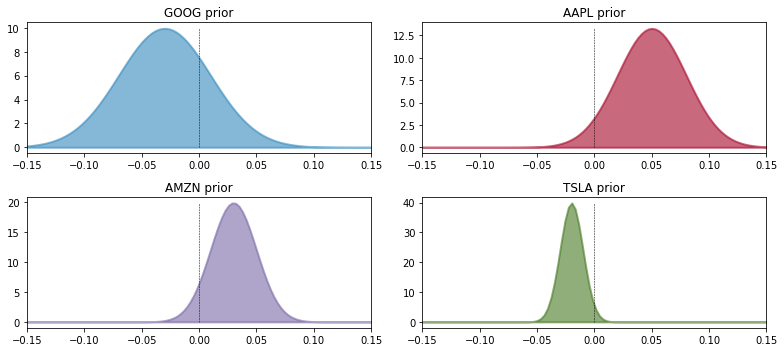

In [2]:
figsize(11.0, 5)
colors = ["#348ABD", "#A60628", "#7A68A6", "#467821"]

normal = stats.norm
x = np.linspace(-0.15, 0.15, 100)

expert_prior_params = {"AAPL":(0.05, 0.03),
        "GOOG":(-0.03, 0.04),
        "TSLA": (-0.02, 0.01),
        "AMZN": (0.03, 0.02),
        }

for i, (name, params) in enumerate(expert_prior_params.iteritems()):
    plt.subplot(2,2,i+1)
    y = normal.pdf( x, params[0], scale=params[1] )
    plt.fill_between(x, 0, y, color=colors[i], linewidth=2,
          edgecolor=colors[i], alpha=0.6)
    plt.title(name + " prior")
    plt.vlines(0, 0, y.max(), "k","--", linewidth=0.5)
    plt.xlim(-0.15, 0.15)
plt.tight_layout()

In [3]:
import pymc as pm


n_observations = 100 # We will truncate the most recent 100 days.

prior_mu = np.array([x[0] for x in expert_prior_params.values()])
prior_std = np.array([x[1] for x in expert_prior_params.values()])

inv_cov_matrix = pm.Wishart("inv_cov_matrix", n_observations, np.diag
                (prior_std**2))
mu = pm.Normal("returns", prior_mu, 1, size=4)

In [12]:

stocks = ["AAPL", "GOOG", "TSLA", "AMZN"]
enddate = datetime.datetime.now().strftime("%Y-%m-%d") # today's date
startdate = "2017-09-01"

for tik in stocks:
    stocks[tik] = pd.DataFrame(web.DataReader(tik, "fred", start = startdate, end = enddate))


RemoteDataError: Unable to read URL: https://fred.stlouisfed.org/graph/fredgraph.csv?id=AAPL

In [4]:
import datetime
import ystockquote as ysq

stocks = ["AAPL", "GOOG", "TSLA", "AMZN"]

enddate = datetime.datetime.now().strftime("%Y-%m-%d") # today's date
startdate = "2017-09-01"

stock_closes = {}
stock_returns = {}
CLOSE = 6

for stock in stocks:
    x = np.array(ysq.get_historical_prices(stock, startdate, enddate))
    stock_closes[stock] = x[1:,CLOSE].astype(float)

for stock in stocks:
    _previous_day = np.roll(stock_closes[stock], -1)
    stock_returns[stock] = ((stock_closes[stock] - _previous_day)/
                         _previous_day)[:n_observations]

dates = map(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"),
    x[1:n_observations+1,0])

figsize(12.5, 4)

for _stock, _returns in stock_returns.iteritems():
    p = plt.plot((1+_returns)[::-1].cumprod()-1, '-o', label="%s"%_stock,
         markersize=4, markeredgecolor="none" )
plt.xticks( np.arange(100)[::-8],
      map(lambda x: datetime.datetime.strftime(x, "%Y-%m-%d"), dates[::8]),
      rotation=60);

plt.legend(loc="upper left")
plt.title("Return space representation of the price of the stocks")
plt.xlabel("Date")
plt.ylabel("Return of $1 on first date, x 100%");



URLError: <urlopen error [Errno 8] nodename nor servname provided, or not known>

In [ ]:
obs = pm.MvNormal("observed returns", mu, inv_cov_matrix, observed=True,
      value=returns)

model = pm.Model([obs, mu, inv_cov_matrix])
mcmc = pm.MCMC()

mcmc.sample(150000, 100000, 3)

Text(0.5,1,'Convergence of posterior distributions (with different priors) as we observe more and more information')

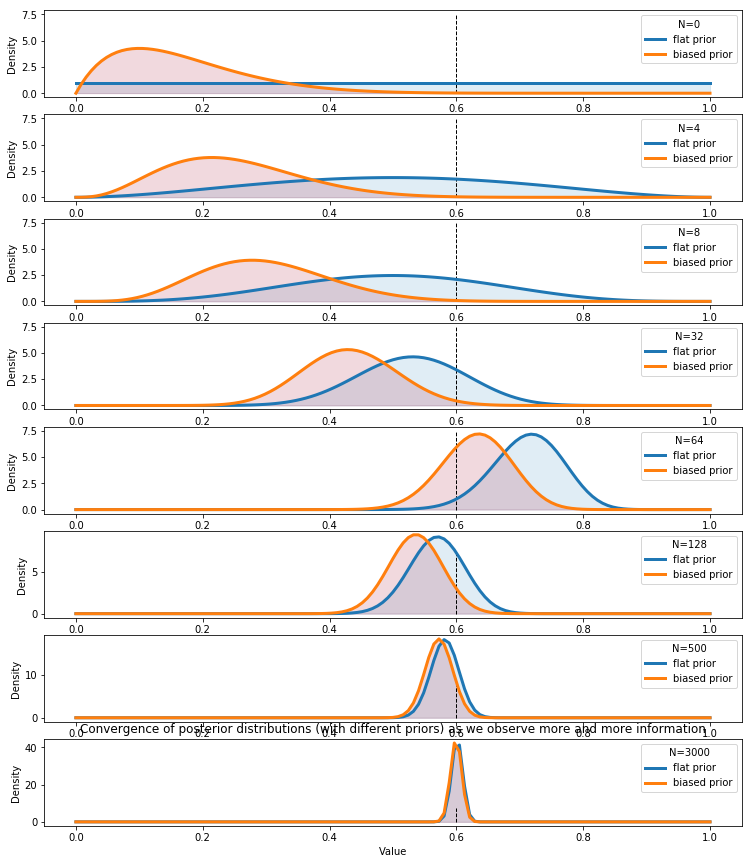

In [18]:
figsize(12.5, 15)

p = 0.6
beta1_params = np.array([1.,1.])
beta2_params = np.array([2,10])
beta = stats.beta

x = np.linspace(0.00, 1, 125)
# data = pm.rbernoulli(p, size=500)

plt.figure()
for i,N in enumerate([0, 4, 8, 32, 64, 128, 500, 3000]):
#     s = data[:N].sum()
    s = pm.rbernoulli(p, size = N).sum()
    plt.subplot(8, 1, i+1)
    params1 = beta1_params + np.array([s, N-s])
    params2 = beta2_params + np.array([s, N-s])
    y1,y2 = beta.pdf(x, *params1), beta.pdf(x, *params2)
    plt.plot(x, y1, label="flat prior", lw =3)
    plt.plot(x, y2, label="biased prior", lw= 3)
    plt.fill_between(x, 0, y1, color="#348ABD", alpha=0.15)
    plt.fill_between(x, 0, y2, color="#A60628", alpha=0.15)
    plt.legend(title="N=%d"%N)
    plt.vlines(p, 0.0, 7.5, linestyles="--", linewidth=1)
    plt.xlabel('Value')
    plt.ylabel('Density')
plt.title("Convergence of posterior distributions (with different priors) as we observe more and more information")